In [ ]:
!pip install transformers trl rouge bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer,AutoModelWithLMHead,GPT2Model,TrainingArguments, pipeline
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from google.colab import drive
import pandas as pd
import random
import math
import torch
import re
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score
import matplotlib.pyplot as plt
from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
german_stop_words = set(stopwords.words('german'))
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
sentiment_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}
classifier = pipeline("sentiment-analysis", model="/content/drive/MyDrive/Masterthesis/Models/sentiment_discriminator_bert_finetuned",**sentiment_pipe_kwargs)


In [ ]:
def convert_sentiment(text):
  if text in["[negative]","NEGATIVE"]:
    return 0
  if text in ["[positive]","POSITIVE"]:
    return 1


def convert_to_sentiment(x):
  if x == 0:
    return "[negative]"
  if x==1:
    return "[positive]"

In [ ]:
def take_10_words(text):
  words = text.split()[:10]
  return " ".join(words)


In [ ]:
def calculate_bleu_score(row):
    reference = row['org_text']
    hypothesis = row['text']

    reference = reference.split()
    hypothesis = hypothesis.split()

    # Calculate the BLEU score
    bleu_score = sentence_bleu([reference], hypothesis)
    return bleu_score


In [ ]:
from rouge import Rouge
def calculate_rouge_score(row):
    reference = str(row['org_text'])
    hypothesis = str(row['text'])

    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    # Calculate the BLEU score

    return scores[0]["rouge-1"]["f"]

In [ ]:
 path="/content/drive/MyDrive/Masterthesis/Data/data_processed/test_for_sft.tsv"
 data_rl=pd.read_csv(path, sep='\t')
 data_rl["sent_str"]=data_rl.sentiment.apply(convert_to_sentiment)
 data_rl["seq_start"]=data_rl.preprocessed_text.apply(take_10_words)
 data_rl["instruction"]=data_rl["sent_str"]+" "+data_rl["seq_start"]

In [ ]:
positive_samples = data_rl[data_rl['sentiment'] == 1]
negative_samples = data_rl[data_rl['sentiment'] == 0]
sampled_positive = positive_samples.sample(n=50, random_state=123)
sampled_negative = negative_samples.sample(n=50, random_state=123)
data_sampled = pd.concat([sampled_positive, sampled_negative])
data_sampled=data_sampled.sample(frac=1, random_state=42)
data_sampled=data_sampled.reset_index()


In [ ]:
def del_stop_words(text):
  words = nltk.word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in german_stop_words]
  return' '.join(filtered_words)

In [ ]:
tokenizer_for_perplex = AutoTokenizer.from_pretrained("distilbert-base-german-cased")
model_for_perplex = AutoModelWithLMHead.from_pretrained("distilbert-base-german-cased")


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

# Testing of original GPT with sentiment control

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("benjamin/gpt2-wechsel-german")
model = AutoModelWithLMHead.from_pretrained("benjamin/gpt2-wechsel-german")
tokenizer.pad_token = tokenizer.eos_token
#sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
    "num_beams":3
}

In [ ]:
df_gpt=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub(r'\[.*?\]', '', generated_text)


  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]
  df_gpt.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_gpt.loc[i,"text"]=generated_text
  df_gpt.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_gpt.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_gpt.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_gpt.loc[i,"sent_predicted_score"]=pred[0][0]["score"]

In [ ]:
df_gpt["sentiment_conv"]=df_gpt["sentiment"].apply(lambda x :convert_sentiment(x))
df_gpt["sent_predicted_label_conv"]=df_gpt["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
np.mean(df_gpt["perplexity"])

1.1151466385533744

In [ ]:
df_gpt["perplexity"]=df_gpt["perplexity"].astype(float)#
df_gpt.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.115071
[positive]    1.115223
Name: perplexity, dtype: float64

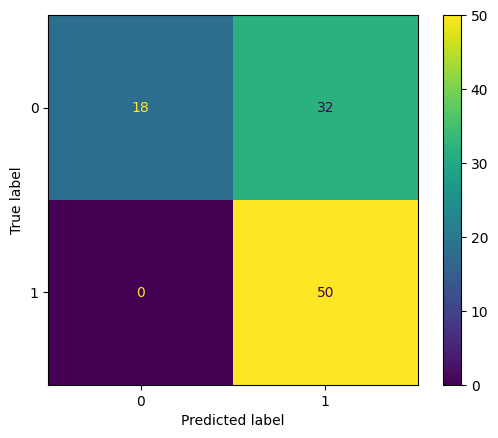

Accuracy: 0.68
Recall: [0.36 1.  ]
Precision: [1.        0.6097561]
F1: [0.52941176 0.75757576]


In [ ]:
y_test=df_gpt["sentiment_conv"]
predicted=df_gpt["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_gpt['rouge_score_f'] = df_gpt.apply(calculate_rouge_score, axis=1)
df_gpt['rouge_score_f'].mean()

0.2916183739968673

In [ ]:
df_gpt['text_del_stop_words']=df_gpt['text'].apply(del_stop_words)
docs = df_gpt['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)


In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.get_topics()

{-1: [('gut', 0.12065265147566824),
  ('hotel', 0.10197264634537552),
  ('sauber', 0.09426803781266109),
  ('zimmer', 0.09295464072608357),
  ('freundlich', 0.07644863194504295),
  ('lage', 0.0629893498902561),
  ('personal', 0.0629893498902561),
  ('frühstück', 0.0508443374718001),
  ('hilfsbereit', 0.04568778327355162),
  ('schön', 0.0412331186539064)]}

In [ ]:
df_gpt.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_GPT_org_longer.tsv", sep="\t")

In [ ]:
df_gpt=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_GPT_org_longer.tsv", sep="\t")
df_gpt.loc[3,"text"]

' Wunderschöner Urlaub, wir kommen wieder Sehr freundlich eingerichtetes Hotel, wunderschöne, saubere Zimmer und Frühstück, sehr gutes Preis-Leistungsverhältnis. Für die Region...\nSehr schönes Hotel mit tollem Pool und schönen Zimmern. Der Pool ist sehr sauber und hat auch eine Sauna. Die Zimmer sind groß und sehr gemütlich. Wir hatten einen sehr schönen Aufenthalt und kommen wieder.\nDas Hotel ist wirklich sehr schön und sauber. Die Zimmer sind auch sehr sauber. Die Betten sind sehr bequem. Das Frühstück ist sehr gut und reichhaltig. Die Mitarbeiter sind sehr freundlich und hilfsbereit. Wir kommen gerne wieder.'

# Testing of models after supervised fine-tuning
## GPT-2 trained one epoch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_1_epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_1_epochs")
tokenizer.pad_token = tokenizer.eos_token
sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
}


In [ ]:
df_sft_1=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub(r'\[.*?\]', '', generated_text)

  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

  df_sft_1.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_sft_1.loc[i,"text"]=generated_text
  df_sft_1.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_sft_1.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_sft_1.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_sft_1.loc[i,"sent_predicted_score"]=pred[0][0]["score"]

In [ ]:
df_sft_1["sentiment_conv"]=df_sft_1["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_1["sent_predicted_label_conv"]=df_sft_1["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
np.mean(df_sft_1["perplexity"])

1.1243964860366513

In [ ]:
df_sft_1["perplexity"]=df_sft_1["perplexity"].astype(float)#
df_sft_1.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.128489
[positive]    1.120304
Name: perplexity, dtype: float64

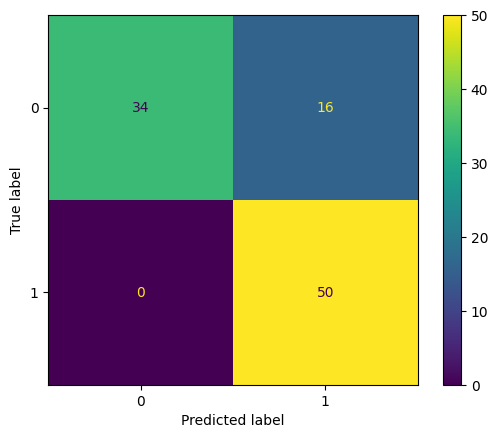

Accuracy: 0.84
Recall: [0.68 1.  ]
Precision: [1.         0.75757576]
F1: [0.80952381 0.86206897]


In [ ]:
y_test=df_sft_1["sentiment_conv"]
predicted=df_sft_1["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_sft_1['rouge_score_f'] = df_sft_1.apply(calculate_rouge_score, axis=1)
df_sft_1['rouge_score_f'].mean()

0.2987514231515142

In [ ]:
df_sft_1['text_del_stop_words']=df_sft_1['text'].apply(del_stop_words)
docs = df_sft_1['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7,-1_immer_flughafen_ca_gut,"[immer, flughafen, ca, gut, minuten, hotel, wu...",[Servicepersonal immer freundlich super schnel...
1,0,74,0_hotel_sauber_essen_gut,"[hotel, sauber, essen, gut, gab, personal, str...","[Toller Urlaub Hotel schön , sauber gepflegt ...."
2,1,19,1_zimmer_bad_klein_betten,"[zimmer, bad, klein, betten, dusche, gewechsel...","[Zimmer normal groß , Einrichtung alt abgewohn..."


In [ ]:
topic_model.get_topics()

{-1: [('immer', 0.17903066009638066),
  ('flughafen', 0.12211075631707381),
  ('ca', 0.11335110919917978),
  ('gut', 0.10837750033597743),
  ('minuten', 0.09702381334870025),
  ('hotel', 0.08970260684205686),
  ('wurde', 0.07633015590918993),
  ('freundlich', 0.07215450078761806),
  ('fahrt', 0.06980531079737398),
  ('direkt', 0.06004759826209398)],
 0: [('hotel', 0.0838067669060768),
  ('sauber', 0.07246004916052709),
  ('essen', 0.06381598777261312),
  ('gut', 0.06216945714102121),
  ('gab', 0.06180095232819862),
  ('personal', 0.056044155637048204),
  ('strand', 0.05423912834885149),
  ('immer', 0.04933196494855802),
  ('gibt', 0.04640214748920522),
  ('freundlich', 0.045971011582138926)],
 1: [('zimmer', 0.17342982667641707),
  ('bad', 0.09870278781360767),
  ('klein', 0.08848366116601397),
  ('betten', 0.08811432700467654),
  ('dusche', 0.08355565918428881),
  ('gewechselt', 0.0804186447665937),
  ('groß', 0.07692592775824397),
  ('tag', 0.07636719772281982),
  ('sauber', 0.074093

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
df_sft_1.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_longer.tsv", sep="\t")

In [ ]:
df_sft_1=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_longer.tsv", sep="\t")
df_sft_1.loc[3,"text"]

' Wunderschöner Urlaub, wir kommen wieder Sehr freundlich eingerichtetes Hotel, wunderschöne, gepflegte Anlage, schöne Zimmer, leckeres Essen, sehr freundliches Personal, wir kommen wieder! Alles sehr sauber und gepflegt.Das Essen ist sehr gut und abwechslungsreich. Für uns war es das schönste Hotel auf Rhodos, wir kommen wieder! Wir hatten eine sehr schöne Zeit in diesem Hotel. Die Animation war sehr nett und freundlich. Das Personal war sehr aufmerksam und hilfsbereit. Das Essen war sehr gut und abwechslungsreich. Wir kommen wieder!Die Animation war sehr nett und hilfsbereit. Das Personal ist sehr freundlich und hilfsbereit.'

##GPT-2 trained two epochs

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_2_epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_2_epochs")
tokenizer.pad_token = tokenizer.eos_token
sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
}


In [ ]:
df_sft_2=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub(r'\[.*?\]', '', generated_text)

  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

  df_sft_2.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_sft_2.loc[i,"text"]=generated_text
  df_sft_2.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_sft_2.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_sft_2.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_sft_2.loc[i,"sent_predicted_score"]=pred[0][0]["score"]

In [ ]:
df_sft_2["sentiment_conv"]=df_sft_2["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_2["sent_predicted_label_conv"]=df_sft_2["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
df_sft_2

,sentiment,text,org_text,perplexity,sent_predicted_label,sent_predicted_score,sentiment_conv,sent_predicted_label_conv
0,[negative],Die Zimmermädchen und Bedienungen im Restaura...,Die Zimmermädchen und Bedienungen im Restauran...,1.05897,NEGATIVE,3.000815,0,0
1,[negative],Vom Sportangebot haben wir außer immer 13.00U...,Vom Sportangebot haben wir außer immer 13.00Uh...,1.252374,POSITIVE,3.599861,0,1
2,[negative],Es wird eigtl sehr wenig Deutsch gesprochen. ...,Es wird eigtl sehr wenig Deutsch gesprochen. S...,1.084474,POSITIVE,0.581641,0,1
3,[positive],"Wunderschöner Urlaub, wir kommen wieder Sehr ...","Wunderschöner Urlaub, wir kommen wieder Sehr f...",1.115752,POSITIVE,3.912795,1,1
4,[positive],Animationen tagsüber haben wir nicht gesucht ...,Animationen tagsüber haben wir nicht gesucht u...,1.227301,POSITIVE,3.828829,1,1
...,...,...,...,...,...,...,...,...
95,[negative],"Keine Luxuszimmer, aber mit Klimaanlage, zum ...","Keine Luxuszimmer, aber mit Klimaanlage, zum s...",1.219189,POSITIVE,3.325199,0,1
96,[negative],Bei Ankunft sah man im Badezimmer sehr viele ...,Bei Ankunft sah man im Badezimmer sehr viele H...,1.172524,NEGATIVE,2.897475,0,0
97,[positive],"Toller Urlaub Das Hotel war sehr schön, saube...","Toller Urlaub Das Hotel war sehr schön, sauber...",1.118293,POSITIVE,3.953387,1,1
98,[negative],Nicht empfehlenswert! Schlechtes Essen! Servi...,Nicht empfehlenswert! Schlechtes Essen! Servic...,1.066483,NEGATIVE,3.373337,0,0


In [ ]:
np.mean(df_sft_2["perplexity"])

1.1329989299184104

In [ ]:
df_sft_2["perplexity"]=df_sft_2["perplexity"].astype(float)#
df_sft_2.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.135583
[positive]    1.130415
Name: perplexity, dtype: float64

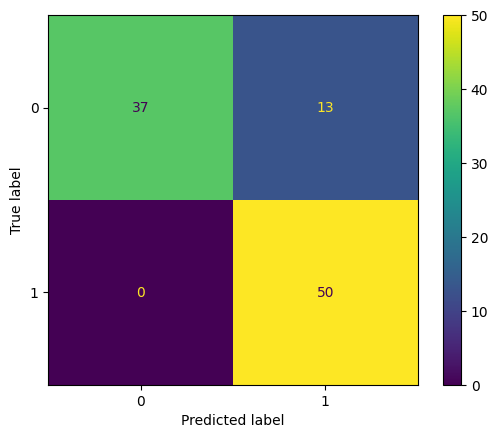

Accuracy: 0.87
Recall: [0.74 1.  ]
Precision: [1.         0.79365079]
F1: [0.85057471 0.88495575]


In [ ]:

y_test=df_sft_2["sentiment_conv"]
predicted=df_sft_2["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_sft_2['rouge_score_f'] = df_sft_2.apply(calculate_rouge_score, axis=1)
df_sft_2['rouge_score_f'].mean()


0.30411446102251094

In [ ]:
df_sft_2['text_del_stop_words']=df_sft_2['text'].apply(del_stop_words)
docs = df_sft_2['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_topics()

{0: [('hotel', 0.09577198263384351),
  ('strand', 0.07404700999819219),
  ('gut', 0.063888575156278),
  ('essen', 0.06249936036101973),
  ('sauber', 0.06016319562353116),
  ('immer', 0.059334072769191115),
  ('personal', 0.05588110624515612),
  ('zimmer', 0.05502653353129548),
  ('gibt', 0.053602362434919205),
  ('gab', 0.04708742528568981)],
 1: [('zimmer', 0.171792479982428),
  ('klimaanlage', 0.1309266510200782),
  ('betten', 0.11008210395709925),
  ('safe', 0.09853876456899262),
  ('bad', 0.0872379089459293),
  ('balkon', 0.08421578867791797),
  ('beqüm', 0.07917031318756679),
  ('ausgestattet', 0.07886934411489785),
  ('klein', 0.07751944817406457),
  ('gibt', 0.0706331477924196)]}

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,82,0_hotel_strand_gut_essen,"[hotel, strand, gut, essen, sauber, immer, per...",[Hause gefühlt . Super Urlaub ! Danke ! Hammer...
1,1,18,1_zimmer_klimaanlage_betten_safe,"[zimmer, klimaanlage, betten, safe, bad, balko...","[Zimmer schön groß sauber . Badewanne klein , ..."


In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
df_sft_2.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_longer.tsv", sep="\t")

##GPT-2 trained three epochs


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_3_epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_3_epochs")
tokenizer.pad_token = tokenizer.eos_token
sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
}

In [ ]:
df_sft_3=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub(r'\[.*?\]', '', generated_text)


  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

  df_sft_3.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_sft_3.loc[i,"text"]=generated_text
  df_sft_3.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_sft_3.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_sft_3.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_sft_3.loc[i,"sent_predicted_score"]=pred[0][0]["score"]


In [ ]:
df_sft_3["sentiment_conv"]=df_sft_3["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_3["sent_predicted_label_conv"]=df_sft_3["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
df_sft_3["text"].values

array([' Die Zimmermädchen und Bedienungen im Restaurant waren sehr nett und zuvorkommend. Die Rezeption war zwar freundlich, aber man hatte das Gefühl, dass man nicht ernst genommen wurde. Die Zimmerreinigung war mangelhaft. Der Zimmerservice war sehr gut. Das Personal an der Rezeption war freundlich und hilfsbereit. Die Kinderbetreuung war mangelhaft. Wir haben uns auf die Abendanimation beschränkt. Die Abendanimation war sehr gut und die Kinder haben sich sehr viel Mühe gegeben. Das Personal an der Rezeption war sehr freundlich und hilfsbereit. Die Kinderbetreuung war mangelhaft. Wir haben die Kinderbetreuung nicht',
       ' Vom Sportangebot haben wir außer immer 13.00Uhr am Pool Ärobic und Wasserball nicht teilgenommen.Abends gibt es im Amphitheater ein Showprogramm. Das ist aber auch schon alles. Die Abendunterhaltung war auch nicht so der Hit. Der Sänger war wirklich sehr schön und auch die Musik war gut.Der Pool war recht groß und die Liegen waren auch in Ordnung. Das Wasser wa

In [ ]:
df_sft_3

,sentiment,text,org_text,perplexity,sent_predicted_label,sent_predicted_score,sentiment_conv,sent_predicted_label_conv
0,[negative],Die Zimmermädchen und Bedienungen im Restaura...,Die Zimmermädchen und Bedienungen im Restauran...,1.057814,POSITIVE,3.297535,0,1
1,[negative],Vom Sportangebot haben wir außer immer 13.00U...,Vom Sportangebot haben wir außer immer 13.00Uh...,1.255907,POSITIVE,3.15149,0,1
2,[negative],Es wird eigtl sehr wenig Deutsch gesprochen. ...,Es wird eigtl sehr wenig Deutsch gesprochen. S...,1.113335,POSITIVE,3.858543,0,1
3,[positive],"Wunderschöner Urlaub, wir kommen wieder Sehr ...","Wunderschöner Urlaub, wir kommen wieder Sehr f...",1.106108,POSITIVE,3.897324,1,1
4,[positive],Animationen tagsüber haben wir nicht gesucht ...,Animationen tagsüber haben wir nicht gesucht u...,1.219931,POSITIVE,3.833949,1,1
...,...,...,...,...,...,...,...,...
95,[negative],"Keine Luxuszimmer, aber mit Klimaanlage, zum ...","Keine Luxuszimmer, aber mit Klimaanlage, zum s...",1.075531,POSITIVE,3.403366,0,1
96,[negative],Bei Ankunft sah man im Badezimmer sehr viele ...,Bei Ankunft sah man im Badezimmer sehr viele H...,1.169901,POSITIVE,3.605835,0,1
97,[positive],"Toller Urlaub Das Hotel war sehr schön, saube...","Toller Urlaub Das Hotel war sehr schön, sauber...",1.136482,POSITIVE,3.938165,1,1
98,[negative],Nicht empfehlenswert! Schlechtes Essen! Servi...,Nicht empfehlenswert! Schlechtes Essen! Servic...,1.085593,NEGATIVE,3.044909,0,0


In [ ]:
np.mean(df_sft_3["perplexity"])

1.1249397338686595

In [ ]:
df_sft_3["perplexity"]=df_sft_3["perplexity"].astype(float)#
df_sft_3.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.129878
[positive]    1.120001
Name: perplexity, dtype: float64

In [ ]:
df_sft_3["sentiment_conv"]=df_sft_3["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_3["sent_predicted_label_conv"]=df_sft_3["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

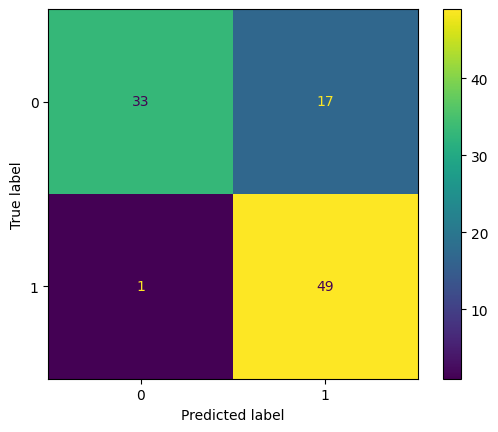

Accuracy: 0.82
Recall: [0.66 0.98]
Precision: [0.97058824 0.74242424]
F1: [0.78571429 0.84482759]


In [ ]:
y_test=df_sft_3["sentiment_conv"]
predicted=df_sft_3["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_sft_3['rouge_score_f'] = df_sft_3.apply(calculate_rouge_score, axis=1)
df_sft_3['rouge_score_f'].mean()

0.29824530654317594

In [ ]:
df_sft_3['text_del_stop_words']=df_sft_3['text'].apply(del_stop_words)
docs = df_sft_3['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_topics()

{-1: [('immer', 0.06754059982873237),
  ('super', 0.06131241297103754),
  ('hotel', 0.06088848747233416),
  ('freundlich', 0.05831424054251796),
  ('ca', 0.055724476858057696),
  ('gut', 0.05511160204000982),
  ('viele', 0.0467156060333055),
  ('strand', 0.041225621725429616),
  ('lage', 0.04086461636257564),
  ('rezeption', 0.04085438391811764)],
 0: [('hotel', 0.09253447767177099),
  ('strand', 0.0840582290345643),
  ('sauber', 0.07425628567255535),
  ('gibt', 0.06774179925304967),
  ('schön', 0.0572226944654867),
  ('freundlich', 0.05376419519492412),
  ('liegen', 0.051437680918720724),
  ('gepflegt', 0.04994064722594992),
  ('personal', 0.0490478195035552),
  ('hilfsbereit', 0.045400798709575134)],
 1: [('eis', 0.09385232474580452),
  ('essen', 0.07707772193911731),
  ('hotel', 0.05875204931541015),
  ('leider', 0.05141702057883277),
  ('schlecht', 0.05141702057883277),
  ('gab', 0.05049919713252513),
  ('unfreundlich', 0.04415140437466748),
  ('gleiche', 0.04187264423899324),
  ('

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
df_sft_3.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_3_longer.tsv", sep="\t")

#After RL
## GPT finetuned SFT for 1 epoch
### RL 1 Epoch



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_1epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_1epochs")
tokenizer.pad_token = tokenizer.eos_token
sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
}

Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_1epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_1_rl_1=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub(r'\[.*?\]', '', generated_text)

  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

  df_sft_1_rl_1.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_sft_1_rl_1.loc[i,"text"]=generated_text
  df_sft_1_rl_1.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_sft_1_rl_1.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_sft_1_rl_1.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_sft_1_rl_1.loc[i,"sent_predicted_score"]=pred[0][0]["score"]


In [ ]:
df_sft_1_rl_1["sentiment_conv"]=df_sft_1_rl_1["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_1_rl_1["sent_predicted_label_conv"]=df_sft_1_rl_1["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
df_sft_1_rl_1["text"].values

array([' Die Zimmermädchen und Bedienungen im Restaurant waren sehr nett und bemüht, aber unfreundlich. Man konnte nicht Deutsch, da nur Englisch gesprochen wurde. Man wurde nicht verstanden. Das Essen war eine Zumutung. Es gab nur das selbe, die Auswahl war nicht ausreichend. Die Atmosphäre war schlecht, die Qualität der Speisen schlecht. Es gab nur einen Kellner der sich um die Gäste kümmerte. Das Zimmer wurde nur oberflächlich gereinigt. Es gab keine Handtücher. Das Bad war dreckig und nicht sauber. Es gab keinen Safe. Der Spiegel war nicht richtig befestigt. Die Zimmer',
       ' Vom Sportangebot haben wir außer immer 13.00Uhr am Pool Ärobic und Wassergymnastik nicht viel gesehen. Die Animateure waren nicht besonders freundlich und auch nicht hilfsbereit. Die Zimmerreinigung war nicht gerade das was wir wollten. Der Strand war sehr dreckig und sehr dreckig. Die Liegen und Sonnenschirme waren sehr alt und teilweise kaputt. Das Wasser war sehr kalt und es war nicht sauber. Die Handtü

In [ ]:
np.mean(df_sft_1_rl_1["perplexity"])

1.1199217623655746

In [ ]:
df_sft_1_rl_1["perplexity"]=df_sft_1_rl_1["perplexity"].astype(float)#
df_sft_1_rl_1.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.124675
[positive]    1.115168
Name: perplexity, dtype: float64

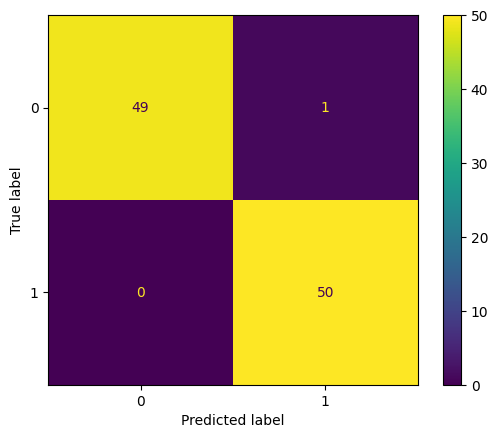

Accuracy: 0.99
Recall: [0.98 1.  ]
Precision: [1.         0.98039216]
F1: [0.98989899 0.99009901]


In [ ]:
y_test=df_sft_1_rl_1["sentiment_conv"]
predicted=df_sft_1_rl_1["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_sft_1_rl_1['rouge_score_f'] = df_sft_1_rl_1.apply(calculate_rouge_score, axis=1)
df_sft_1_rl_1['rouge_score_f'].mean()

0.30721062502218305

In [ ]:
df_sft_1_rl_1['text_del_stop_words']=df_sft_1_rl_1['text'].apply(del_stop_words)
docs = df_sft_1_rl_1['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_topics()

{0: [('schlecht', 0.11686326211116674),
  ('essen', 0.09721236133103567),
  ('gab', 0.0950204411539139),
  ('unfreundlich', 0.09326872630857638),
  ('dreckig', 0.08981432903788837),
  ('zimmer', 0.08781525016442224),
  ('personal', 0.07940171401635839),
  ('telefon', 0.0744251275329861),
  ('safe', 0.0710469078447261),
  ('handtücher', 0.06410753516051546)],
 1: [('gut', 0.12462052547051156),
  ('freundlich', 0.11152665378446978),
  ('personal', 0.11017676712217403),
  ('hotel', 0.10600579611252033),
  ('hilfsbereit', 0.10533072857422146),
  ('immer', 0.10146452489197155),
  ('zimmer', 0.09972065051620835),
  ('sauber', 0.0952058614087159),
  ('strand', 0.08408776412622786),
  ('essen', 0.07552506592906506)]}

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,50,0_schlecht_essen_gab_unfreundlich,"[schlecht, essen, gab, unfreundlich, dreckig, ...","[schlechtester Urlaub Zeiten große Anlage , we..."
1,1,50,1_gut_freundlich_personal_hotel,"[gut, freundlich, personal, hotel, hilfsbereit...",[schönes Hotel schon zweite mal kommen . Perso...


In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
df_sft_1_rl_1.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_rl_1_longer.tsv", sep="\t")

In [ ]:
df_sft_1_rl_1=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_rl_1_longer.tsv", sep="\t")
df_sft_1_rl_1.loc[3,"text"]

' Wunderschöner Urlaub, wir kommen wieder Sehr freundlich eingerichtetes Hotel, wunderschöne, saubere Zimmer. Das Essen war gut, abwechslungsreich und sehr gut. Das Personal ist sehr nett und hilfsbereit. Wir kommen wieder. Sehr gutes Essen. Es gibt einen schönen Strand. Wir kommen wieder. Das Personal ist sehr nett und hilfsbereit. Das Essen ist gut. Wir kommen wieder. Sehr gutes Hotel. Das Personal ist sehr freundlich und hilfsbereit. Wir kommen wieder. Sehr gutes Essen. Wir kommen wieder. Sehr gutes Hotel. Das Personal ist sehr freundlich und hilfsbereit. Wir kommen wieder. Sehr gutes Essen.'

### RL 2 Epochs

(floral-cosmos-97)

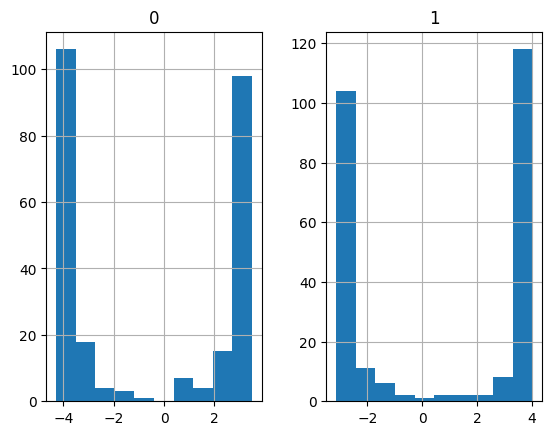

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_2epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_2epochs")
tokenizer.pad_token = tokenizer.eos_token
sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
}

Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_2epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_1_rl_2=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub(r'\[.*?\]', '', generated_text)

  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

  df_sft_1_rl_2.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_sft_1_rl_2.loc[i,"text"]=generated_text
  df_sft_1_rl_2.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_sft_1_rl_2.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_sft_1_rl_2.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_sft_1_rl_2.loc[i,"sent_predicted_score"]=pred[0][0]["score"]

In [ ]:
df_sft_1_rl_2["sentiment_conv"]=df_sft_1_rl_2["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_1_rl_2["sent_predicted_label_conv"]=df_sft_1_rl_2["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
np.mean(df_sft_1_rl_2["perplexity"])

1.1201171936351324

In [ ]:
df_sft_1_rl_2["perplexity"]=df_sft_1_rl_2["perplexity"].astype(float)#
df_sft_1_rl_2.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.124570
[positive]    1.115664
Name: perplexity, dtype: float64

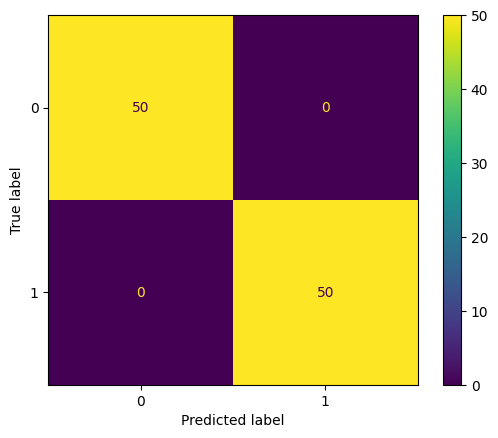

Accuracy: 1.0
Recall: [1. 1.]
Precision: [1. 1.]
F1: [1. 1.]


In [ ]:
y_test=df_sft_1_rl_2["sentiment_conv"]
predicted=df_sft_1_rl_2["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_sft_1_rl_2['rouge_score_f'] = df_sft_1_rl_2.apply(calculate_rouge_score, axis=1)
df_sft_1_rl_2['rouge_score_f'].mean()

0.3168067882756343

In [ ]:
df_sft_1_rl_2['text_del_stop_words']=df_sft_1_rl_2['text'].apply(del_stop_words)
docs = df_sft_1_rl_2['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_topics()

{0: [('gut', 0.1530056633900453),
  ('zimmer', 0.12467599122540793),
  ('sauber', 0.11714457562071685),
  ('personal', 0.10652557408417739),
  ('immer', 0.10140066382389734),
  ('essen', 0.090804083492188),
  ('freundlich', 0.09011768154530866),
  ('schön', 0.07658532502051058),
  ('hotel', 0.07521369181612635),
  ('gab', 0.07125555688109673)],
 1: [('dreckig', 0.12139846558025093),
  ('zimmer', 0.1093797702928934),
  ('unfreundlich', 0.09206947777854382),
  ('schlecht', 0.08015541559851076),
  ('hotel', 0.06939968069174768),
  ('personal', 0.05874905409285703),
  ('sauber', 0.058377798190581316),
  ('total', 0.05595044291558134),
  ('gab', 0.05564944678686039),
  ('essen', 0.05379874876078339)]}

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,58,0_gut_zimmer_sauber_personal,"[gut, zimmer, sauber, personal, immer, essen, ...",[Familiär freundlich familiär geführten Hotel ...
1,1,42,1_dreckig_zimmer_unfreundlich_schlecht,"[dreckig, zimmer, unfreundlich, schlecht, hote...",[Hotel Club Calimera Hurghada wurden Hotel sch...


In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
df_sft_1_rl_2.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_rl_2_longer.tsv", sep="\t")

## GPT finetuned SFT for 2 epoch
### RL 1 Epoch

fine-feather-100



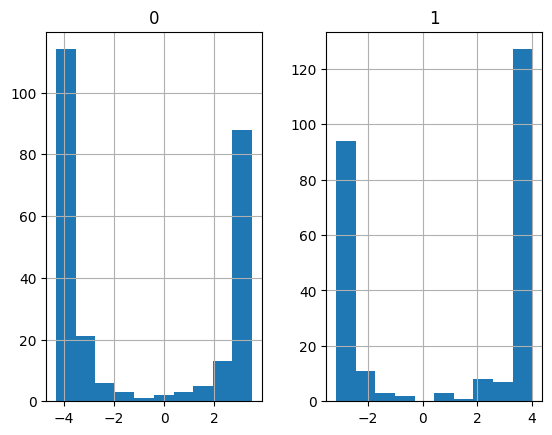

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_1epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_1epochs")
tokenizer.pad_token = tokenizer.eos_token
sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
}

Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_1epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_2_rl_1=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub(r'\[.*?\]', '', generated_text)

  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

  df_sft_2_rl_1.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_sft_2_rl_1.loc[i,"text"]=generated_text
  df_sft_2_rl_1.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_sft_2_rl_1.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_sft_2_rl_1.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_sft_2_rl_1.loc[i,"sent_predicted_score"]=pred[0][0]["score"]

In [ ]:
df_sft_2_rl_1["sentiment_conv"]=df_sft_2_rl_1["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_2_rl_1["sent_predicted_label_conv"]=df_sft_2_rl_1["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
np.mean(df_sft_2_rl_1["perplexity"])

1.120310136148516

In [ ]:
df_sft_2_rl_1["perplexity"]=df_sft_2_rl_1["perplexity"].astype(float)#
df_sft_2_rl_1.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.117474
[positive]    1.123146
Name: perplexity, dtype: float64

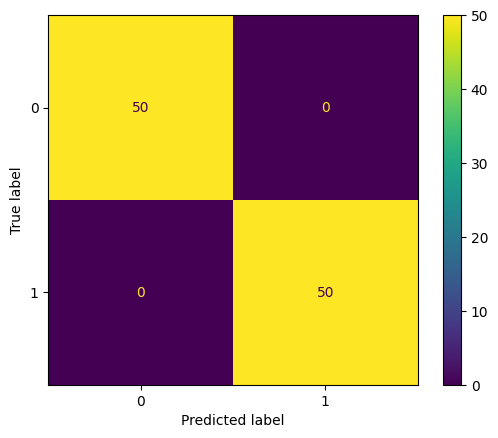

Accuracy: 1.0
Recall: [1. 1.]
Precision: [1. 1.]
F1: [1. 1.]


In [ ]:
y_test=df_sft_2_rl_1["sentiment_conv"]
predicted=df_sft_2_rl_1["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_sft_2_rl_1['rouge_score_f'] = df_sft_2_rl_1.apply(calculate_rouge_score, axis=1)
df_sft_2_rl_1['rouge_score_f'].mean()

0.30827282585682236

In [ ]:
df_sft_2_rl_1['text_del_stop_words']=df_sft_2_rl_1['text'].apply(del_stop_words)
docs = df_sft_2_rl_1['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_topics()

{0: [('gut', 0.12625069143723186),
  ('immer', 0.10259365913968453),
  ('strand', 0.09757328134618515),
  ('essen', 0.0972997987145753),
  ('sauber', 0.09504556300279093),
  ('hotel', 0.09393428355906314),
  ('personal', 0.08295069441534489),
  ('gutes', 0.08284969313151842),
  ('freundlich', 0.08207163851083107),
  ('super', 0.08179844279387412)],
 1: [('dreckig', 0.19463472609068505),
  ('gewechselt', 0.10487096274217295),
  ('unfreundlich', 0.1011369549643623),
  ('gab', 0.09225178608363394),
  ('wurden', 0.09197176205758505),
  ('zimmer', 0.08669669277491743),
  ('personal', 0.07926260729994529),
  ('schlecht', 0.07565396559113917),
  ('handtücher', 0.0716354301282898),
  ('wurde', 0.06278279732423801)]}

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,56,0_gut_immer_strand_essen,"[gut, immer, strand, essen, sauber, hotel, per...","[Toller Urlaub Hotel schön , sauber gepflegt ...."
1,1,44,1_dreckig_gewechselt_unfreundlich_gab,"[dreckig, gewechselt, unfreundlich, gab, wurde...",[Nie Hotel Playamar ! Woche Hotel . Zimmer dre...


In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
df_sft_2_rl_1.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_rl_1_longer.tsv", sep="\t")

## RL 2


vital-lion-101



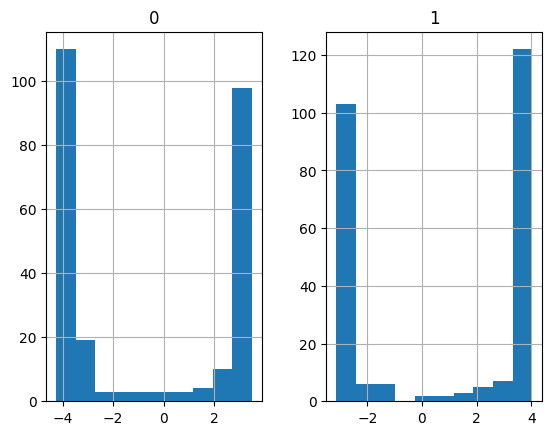

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_2epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_2epochs")
tokenizer.pad_token = tokenizer.eos_token
sentiment=["[positive]","[negative]"]
generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
}

Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_2epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_2_rl_2=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score"])

for i in range(100):
  prompt=data_sampled.loc[i,"instruction"]
  #prompt_sent=random.sample(sentiment,1)[0]
  input_ids = tokenizer.encode(prompt, return_tensors="pt")
  output = model.generate(input_ids, **generation_kwargs)
  generated_text = tokenizer.decode(output[0])
  generated_text=re.sub('\[.*?\]', '', generated_text)

  tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
  tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
  loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

  df_sft_2_rl_2.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
  df_sft_2_rl_2.loc[i,"text"]=generated_text
  df_sft_2_rl_2.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
  df_sft_2_rl_2.loc[i,"perplexity"]=math.exp(loss)
  pred=classifier(generated_text)
  df_sft_2_rl_2.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
  df_sft_2_rl_2.loc[i,"sent_predicted_score"]=pred[0][0]["score"]

In [ ]:
df_sft_2_rl_2["sentiment_conv"]=df_sft_2_rl_2["sentiment"].apply(lambda x :convert_sentiment(x))
df_sft_2_rl_2["sent_predicted_label_conv"]=df_sft_2_rl_2["sent_predicted_label"].apply(lambda x :convert_sentiment(x))

In [ ]:
np.mean(df_sft_2_rl_2["perplexity"])

1.1119660795655648

In [ ]:
df_sft_2_rl_2["perplexity"]=df_sft_2_rl_2["perplexity"].astype(float)#
df_sft_2_rl_2.groupby("sentiment").mean()["perplexity"]

sentiment
[negative]    1.113547
[positive]    1.110385
Name: perplexity, dtype: float64

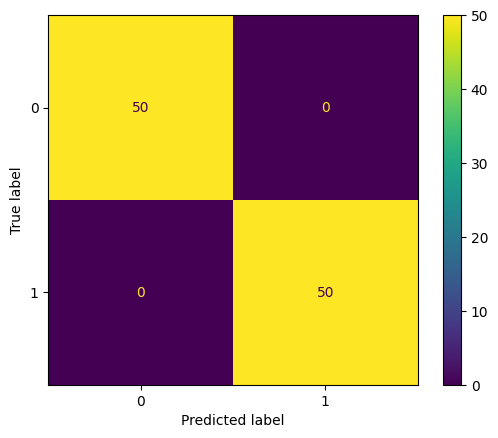

Accuracy: 1.0
Recall: [1. 1.]
Precision: [1. 1.]
F1: [1. 1.]


In [ ]:
y_test=df_sft_2_rl_2["sentiment_conv"]
predicted=df_sft_2_rl_2["sent_predicted_label_conv"]

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("F1:", f1)

In [ ]:
df_sft_2_rl_2['rouge_score_f'] = df_sft_2_rl_2.apply(calculate_rouge_score, axis=1)
df_sft_2_rl_2['rouge_score_f'].mean()

0.3077771948967199

In [ ]:
df_sft_2_rl_2['text_del_stop_words']=df_sft_2_rl_2['text'].apply(del_stop_words)
docs = df_sft_2_rl_2['text_del_stop_words']
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(docs)
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_topics()

{-1: [('immer', 0.1964534145321064),
  ('tag', 0.15708038100228647),
  ('frische', 0.14013538723197552),
  ('gereinigt', 0.12987681086102706),
  ('gab', 0.10844341451988834),
  ('hilfsbereit', 0.10687927507765517),
  ('wurden', 0.0980949821497425),
  ('ordentlich', 0.09154208427300019),
  ('handtücher', 0.08241100069555604),
  ('rezeption', 0.07978958210026466)],
 0: [('hotel', 0.12058480384324116),
  ('gut', 0.11150852828514773),
  ('animation', 0.09393921595146364),
  ('kommen', 0.09379004888935866),
  ('personal', 0.07642538631746497),
  ('freundlich', 0.07078494255800653),
  ('sauber', 0.07034071295484043),
  ('immer', 0.06558868580274753),
  ('nett', 0.06162463388482005),
  ('gibt', 0.056467532960970915)],
 1: [('schlecht', 0.08962072244264829),
  ('essen', 0.08847174819235129),
  ('gab', 0.07651319942373867),
  ('dreckig', 0.06655897583812555),
  ('unfreundlich', 0.06504085431368237),
  ('obst', 0.060015563593629924),
  ('die', 0.05589300252067233),
  ('personal', 0.0526863829076

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6,-1_immer_tag_frische_gereinigt,"[immer, tag, frische, gereinigt, gab, hilfsber...",[Service wirklich überzeugend ... Beschwerden ...
1,0,40,0_hotel_gut_animation_kommen,"[hotel, gut, animation, kommen, personal, freu...",[schönste Urlaub überhaupt Super schöne Hotela...
2,1,38,1_schlecht_essen_gab_dreckig,"[schlecht, essen, gab, dreckig, unfreundlich, ...",[Zimmermädchen Bedienungen Restaurant nett bem...
3,2,16,2_zimmer_sauber_betten_gewechselt,"[zimmer, sauber, betten, gewechselt, gab, hand...","[Zimmer Klimaanlage ausgestattet , jedoch konn..."


In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
 df_sft_2_rl_2.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_rl_2_longer.tsv", sep="\t")